In [1]:
import xarray as xr

import glob
import os
import datetime as dt

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd

In [2]:
start = "2022-06-01"
end = "2022-08-31"

## Prepare tide data

In [3]:
# Download hourly tide data from NOAA: https://tidesandcurrents.noaa.gov/waterlevels.html?id=9449880 -- have to select "hourly" to be able to download more than 30 days of data
tide_df = pd.read_csv("tide_data/FHL_tide_Jul2021-Jun2023.csv", index_col=0)
tide_df

,Date,Time (GMT),Predicted (ft),Preliminary (ft),Verified (ft)
0,2021/07/15,00:00,1.610,-,1.92
1,2021/07/15,01:00,3.175,-,3.55
2,2021/07/15,02:00,4.843,-,5.11
3,2021/07/15,03:00,6.327,-,6.53
4,2021/07/15,04:00,7.378,-,7.49
...,...,...,...,...,...
8203,2023/06/22,19:00,0.465,-,-
8204,2023/06/22,20:00,-0.517,-,-
8205,2023/06/22,21:00,-0.914,-,-
8206,2023/06/22,22:00,-0.641,-,-


In [4]:
tide_df['Verified (ft)'].replace('-', np.NaN, inplace=True) # change the missing values currently represented as "-" to NaNs
tide_df['Verified (ft)'] = tide_df['Verified (ft)'].astype(float) # convert the strings to float values

In [5]:
# Concatenate the date and hour information
tide_df['datetime'] = tide_df[tide_df.columns[0:2]].apply(lambda x: ' '.join(x), axis=1)
tide_df['datetime'] = pd.to_datetime(tide_df['datetime'])
# Make datetime the index of the dataframe so that we can slice the dataframe by date/time afterwards
tide_df = tide_df.set_index('datetime')
# Change the timezone from UTC to Pacific
tide_df.index = tide_df.index.tz_localize('UTC').tz_convert('US/Pacific')
# remove the tz = 'US/Pacific' information in the datetime index because it will cause some error in plotting later
tide_df.index = tide_df.index.tz_localize(None) 

In [6]:
df = tide_df.loc[start:end]
df

,Date,Time (GMT),Predicted (ft),Preliminary (ft),Verified (ft)
datetime,,,,,
2022-06-01 00:00:00,2022/06/01,07:00,7.075,-,6.92
2022-06-01 01:00:00,2022/06/01,08:00,6.888,-,6.73
2022-06-01 02:00:00,2022/06/01,09:00,6.836,-,6.74
2022-06-01 03:00:00,2022/06/01,10:00,6.865,-,6.81
2022-06-01 04:00:00,2022/06/01,11:00,6.892,-,6.87
...,...,...,...,...,...
2022-08-31 19:00:00,2022/09/01,02:00,6.682,-,7.20
2022-08-31 20:00:00,2022/09/01,03:00,7.164,-,7.56
2022-08-31 21:00:00,2022/09/01,04:00,7.091,-,7.45


In [7]:
df.describe()

,Predicted (ft),Verified (ft)
count,2208.000000,1848.000000
mean,4.387800,4.647662
std,2.800955,2.695788
min,-3.608000,-3.050000
25%,2.454500,2.777500
50%,4.995000,5.210000
75%,6.755500,6.920000
max,8.696000,8.960000


In [8]:
# Calculate the 25%, 35%, 50% (quantile?) of the tidal range
quantile_25 = np.quantile(df['Predicted (ft)'], 0.25)
quantile_35 = np.quantile(df['Predicted (ft)'], 0.35)
quantile_50 = np.quantile(df['Predicted (ft)'], 0.50)

In [9]:
midday_tide = df[df.index.hour.isin(range(11,13))]
low_25 = (midday_tide['Predicted (ft)'] <= quantile_25).sum()
low_35 = ((midday_tide['Predicted (ft)'] > quantile_25) & (midday_tide['Predicted (ft)'] <= quantile_35)).sum() # need to  have parentheses around each condition
low_50 = ((midday_tide['Predicted (ft)'] > quantile_35) & (midday_tide['Predicted (ft)'] <= quantile_50)).sum()
high_50 = (midday_tide['Predicted (ft)'] > quantile_50).sum()
print(low_25, low_35, low_50, high_50)

118 29 33 4


## Prepare cloud height data: focus on NaN values indicating clear sky

In [10]:
falsebay = pd.read_csv('cloud_height_timeseries/falsebay_cloudheight_df.csv', index_col='time', parse_dates=True)
falsebay = falsebay[start:end]
falsebay

,latitude,longitude,Height
time,,,
2022-06-01 00:01:17,48.476114,-123.056412,9314.5120
2022-06-01 00:06:17,48.476114,-123.056412,9200.3650
2022-06-01 00:11:17,48.476114,-123.056412,9238.5170
2022-06-01 00:16:17,48.476114,-123.056412,9175.6450
2022-06-01 00:21:17,48.476114,-123.056412,9113.3830
...,...,...,...
2022-08-31 22:36:17,48.476114,-123.056412,NaN
2022-08-31 22:41:17,48.476114,-123.056412,NaN
2022-08-31 22:46:17,48.476114,-123.056412,NaN


In [11]:
cp = pd.read_csv('cloud_height_timeseries/cattlepoint_cloudheight_df.csv', index_col='time', parse_dates=True)
cp = cp[start:end]
cp

,latitude,longitude,Height
time,,,
2022-06-01 00:01:17,48.454967,-122.961251,9314.5120
2022-06-01 00:06:17,48.454967,-122.961251,9200.3650
2022-06-01 00:11:17,48.454967,-122.961251,9238.5170
2022-06-01 00:16:17,48.454967,-122.961251,9175.6450
2022-06-01 00:21:17,48.454967,-122.961251,9113.3830
...,...,...,...
2022-08-31 22:36:17,48.454967,-122.961251,NaN
2022-08-31 22:41:17,48.454967,-122.961251,NaN
2022-08-31 22:46:17,48.454967,-122.961251,NaN


In [12]:
fhl = pd.read_csv('cloud_height_timeseries/fhl_cloudheight_df.csv', index_col='time', parse_dates=True)
fhl = fhl[start:end]
fhl

,latitude,longitude,Height
time,,,
2022-06-01 00:01:17,48.550129,-123.014118,9019.38000
2022-06-01 00:06:17,48.550129,-123.014118,9153.06000
2022-06-01 00:11:17,48.550129,-123.014118,9100.25900
2022-06-01 00:16:17,48.550129,-123.014118,9031.89400
2022-06-01 00:21:17,48.550129,-123.014118,9192.43100
...,...,...,...
2022-08-31 22:36:17,48.550129,-123.014118,NaN
2022-08-31 22:41:17,48.550129,-123.014118,NaN
2022-08-31 22:46:17,48.550129,-123.014118,53.71585


## Plot tide and NaN cloud height values together

Text(0.5, 1.0, 'Tidal height and clear sky timing')

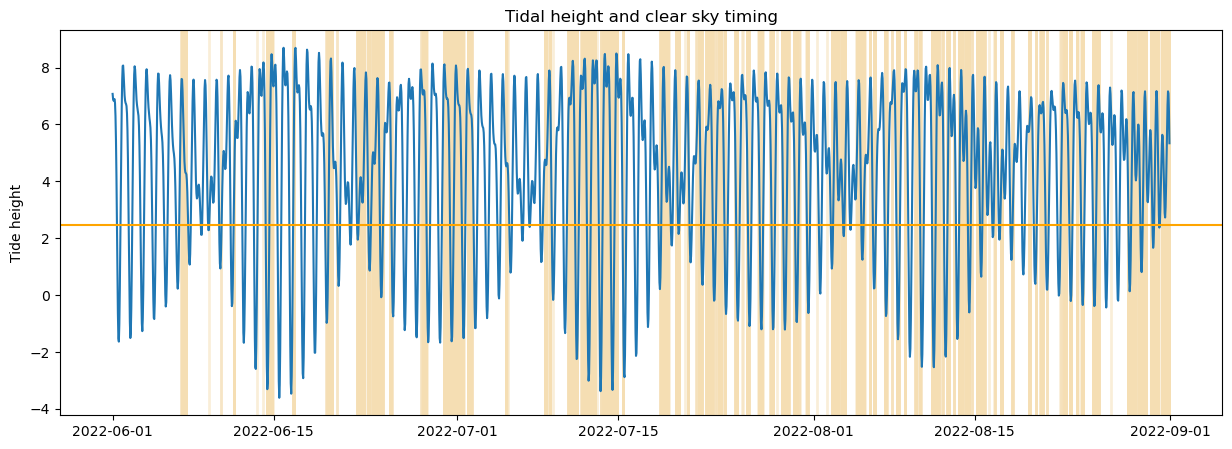

In [13]:
fig, ax1 = plt.subplots(figsize = (15,5))

for i in range(len(falsebay)):
	if np.isnan(falsebay["Height"][i]):
		clear_sky_line = ax1.axvspan(falsebay.index[i], falsebay.index[i], color='wheat', alpha=0.5, linewidth=2, label='No clouds detected')
			
ax1.plot(df.index, df["Predicted (ft)"],color = "tab:blue", alpha = 1, label = "Predicted Tide")
ax1.axhline(2.45, color='orange')
ax1.set_ylabel("Tide height")
# ax1.legend() # look into this: https://stackoverflow.com/questions/60213102/matplotlib-legend-makes-the-image-too-large
plt.title("Tidal height and clear sky timing")

Text(0.5, 1.0, 'Tidal height and clear sky timing')

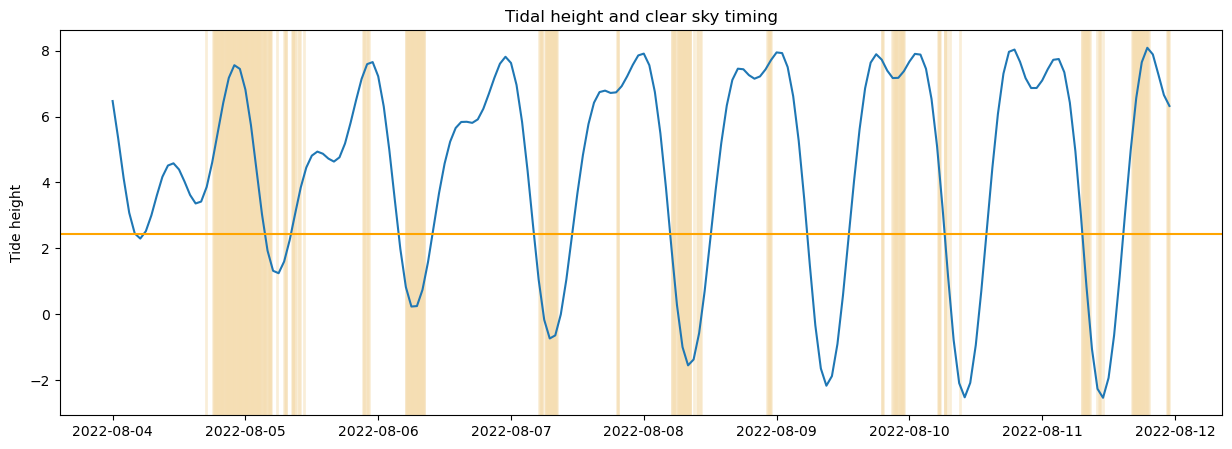

In [14]:
fig, ax1 = plt.subplots(figsize = (15,5))
start = "2022-08-04"
end = "2022-08-11"
a = falsebay[start:end]
b = df[start:end]

for i in range(len(a)):
	if np.isnan(a["Height"][i]):
			clear_sky_line = ax1.axvspan(a.index[i], a.index[i], color='wheat', alpha=0.5, linewidth=2, label='No clouds detected')
			
ax1.plot(b.index, b["Predicted (ft)"],color = "tab:blue", alpha = 1, label = "Predicted Tide")
ax1.axhline(2.45, color='orange')
ax1.set_ylabel("Tide height")
# ax1.legend() # look into this: https://stackoverflow.com/questions/60213102/matplotlib-legend-makes-the-image-too-large
plt.title("Tidal height and clear sky timing")

Text(0.5, 1.0, 'Tidal height and clear sky timing')

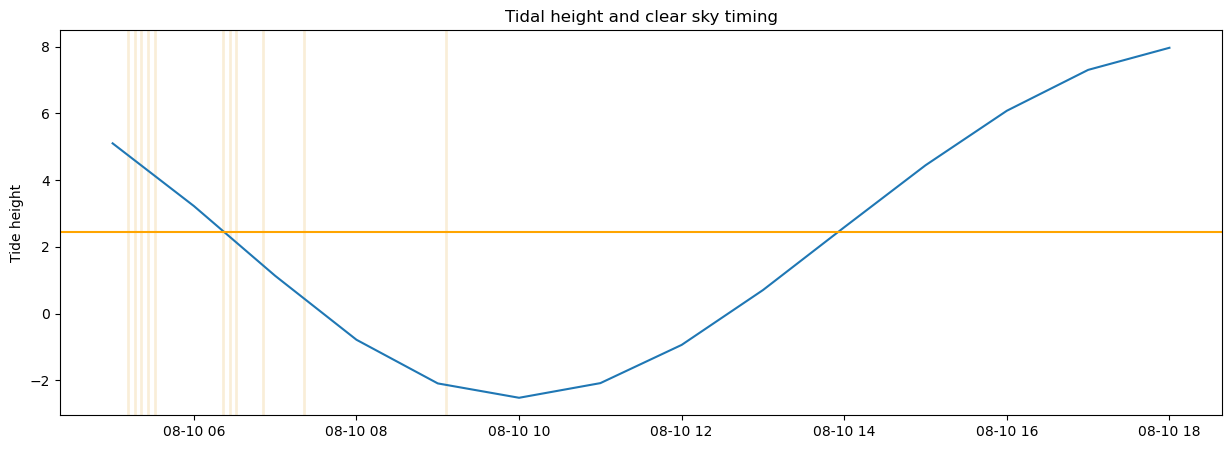

In [15]:
start = "2022-08-10 05:00:00"
end = "2022-08-10 18:00:00"

fig, ax1 = plt.subplots(figsize = (15,5))

a = falsebay[start:end]
b = df[start:end]

for i in range(len(a)):
	if np.isnan(a["Height"][i]):
			clear_sky_line = ax1.axvspan(a.index[i], a.index[i], color='wheat', alpha=0.5, linewidth=2, label='No clouds detected')
			
ax1.plot(b.index, b["Predicted (ft)"],color = "tab:blue", alpha = 1, label = "Predicted Tide")
ax1.axhline(2.45, color='orange')
ax1.set_ylabel("Tide height")
# ax1.legend() # look into this: https://stackoverflow.com/questions/60213102/matplotlib-legend-makes-the-image-too-large
plt.title("Tidal height and clear sky timing")

Text(0.5, 1.0, 'Tidal height and clear sky timing')

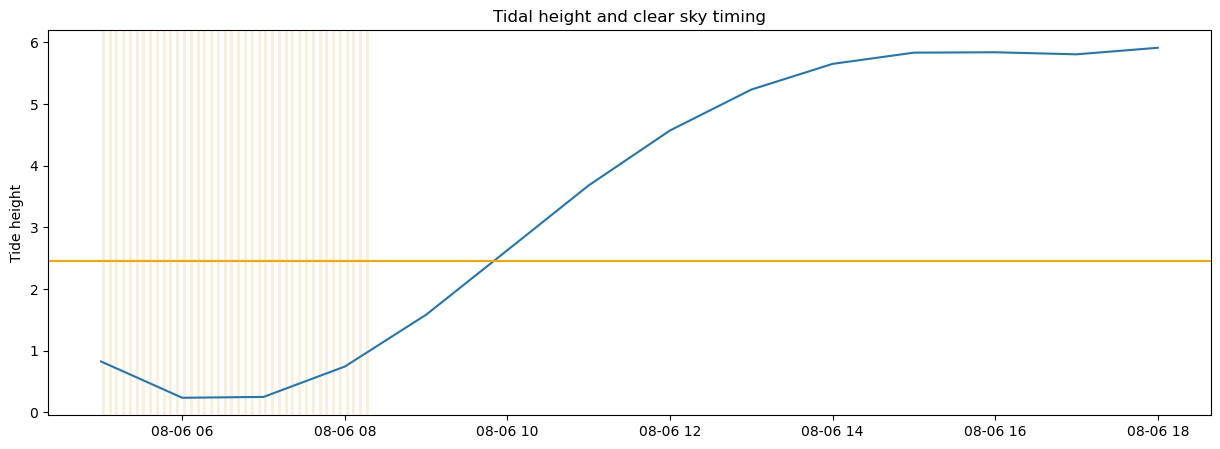

In [16]:
start = "2022-08-06 05:00:00"
end = "2022-08-06 18:00:00"

fig, ax1 = plt.subplots(figsize = (15,5))

a = falsebay[start:end]
b = df[start:end]

for i in range(len(a)):
	if np.isnan(a["Height"][i]):
			clear_sky_line = ax1.axvspan(a.index[i], a.index[i], color='wheat', alpha=0.5, linewidth=2, label='No clouds detected')
			
ax1.plot(b.index, b["Predicted (ft)"],color = "tab:blue", alpha = 1, label = "Predicted Tide")
ax1.axhline(2.45, color='orange')
ax1.set_ylabel("Tide height")
# ax1.legend() # look into this: https://stackoverflow.com/questions/60213102/matplotlib-legend-makes-the-image-too-large
plt.title("Tidal height and clear sky timing")

## Combine 2 dataframes, interpolate tide height values
Interpolate tide heights because tide heights are continuous.

Not interpolate cloud heights because they are not continuous.

### False Bay

In [13]:
combined = pd.concat([df, falsebay], axis=1)

In [14]:
combined[:14] # before interpolating

,Date,Time (GMT),Predicted (ft),Preliminary (ft),Verified (ft),latitude,longitude,Height
2022-06-01 00:00:00,2022/06/01,07:00,7.075,-,6.92,NaN,NaN,NaN
2022-06-01 00:01:17,NaN,NaN,NaN,NaN,NaN,48.476114,-123.056412,9314.512
2022-06-01 00:06:17,NaN,NaN,NaN,NaN,NaN,48.476114,-123.056412,9200.365
2022-06-01 00:11:17,NaN,NaN,NaN,NaN,NaN,48.476114,-123.056412,9238.517
2022-06-01 00:16:17,NaN,NaN,NaN,NaN,NaN,48.476114,-123.056412,9175.645
2022-06-01 00:21:17,NaN,NaN,NaN,NaN,NaN,48.476114,-123.056412,9113.383
2022-06-01 00:26:17,NaN,NaN,NaN,NaN,NaN,48.476114,-123.056412,9208.911
2022-06-01 00:31:17,NaN,NaN,NaN,NaN,NaN,48.476114,-123.056412,9431.405
2022-06-01 00:36:17,NaN,NaN,NaN,NaN,NaN,48.476114,-123.056412,9554.402
2022-06-01 00:41:17,NaN,NaN,NaN,NaN,NaN,48.476114,-123.056412,9320.311


In [15]:
# Interpolate all the NaN values between the two available values as evenly spaced values 
combined["Interpolated_predicted_tide"] = combined["Predicted (ft)"].interpolate(method='linear')

In [16]:
combined[:14] # after interpolating

,Date,Time (GMT),Predicted (ft),Preliminary (ft),Verified (ft),latitude,longitude,Height,Interpolated_predicted_tide
2022-06-01 00:00:00,2022/06/01,07:00,7.075,-,6.92,NaN,NaN,NaN,7.075000
2022-06-01 00:01:17,NaN,NaN,NaN,NaN,NaN,48.476114,-123.056412,9314.512,7.060615
2022-06-01 00:06:17,NaN,NaN,NaN,NaN,NaN,48.476114,-123.056412,9200.365,7.046231
2022-06-01 00:11:17,NaN,NaN,NaN,NaN,NaN,48.476114,-123.056412,9238.517,7.031846
2022-06-01 00:16:17,NaN,NaN,NaN,NaN,NaN,48.476114,-123.056412,9175.645,7.017462
2022-06-01 00:21:17,NaN,NaN,NaN,NaN,NaN,48.476114,-123.056412,9113.383,7.003077
2022-06-01 00:26:17,NaN,NaN,NaN,NaN,NaN,48.476114,-123.056412,9208.911,6.988692
2022-06-01 00:31:17,NaN,NaN,NaN,NaN,NaN,48.476114,-123.056412,9431.405,6.974308
2022-06-01 00:36:17,NaN,NaN,NaN,NaN,NaN,48.476114,-123.056412,9554.402,6.959923
2022-06-01 00:41:17,NaN,NaN,NaN,NaN,NaN,48.476114,-123.056412,9320.311,6.945538


In [17]:
# Remove the rows without any values from cloud height dataframe (where lat, lon, and height are all NaNs, so that it doesn't get calculated together with the  NaN values indicating clear sky)
combined.dropna(subset=['latitude', 'longitude'], inplace=True)

In [18]:
# only look at midday time (11:00 to 13:00), the hottest time of the day, following the Helmuth 2002 paper
combined_midday = combined[combined.index.hour.isin(range(11,13))] # remove .dt when encountering error 'DatetimeIndex' object has no attribute 'dt'

In [19]:
combined_midday

,Date,Time (GMT),Predicted (ft),Preliminary (ft),Verified (ft),latitude,longitude,Height,Interpolated_predicted_tide
2022-06-01 11:01:17,NaN,NaN,NaN,NaN,NaN,48.476114,-123.056412,7582.7860,-0.695538
2022-06-01 11:06:17,NaN,NaN,NaN,NaN,NaN,48.476114,-123.056412,8059.2090,-0.764077
2022-06-01 11:11:17,NaN,NaN,NaN,NaN,NaN,48.476114,-123.056412,7591.0264,-0.832615
2022-06-01 11:16:17,NaN,NaN,NaN,NaN,NaN,48.476114,-123.056412,7715.8550,-0.901154
2022-06-01 11:21:17,NaN,NaN,NaN,NaN,NaN,48.476114,-123.056412,7932.2440,-0.969692
...,...,...,...,...,...,...,...,...,...
2022-08-31 12:36:17,NaN,NaN,NaN,NaN,NaN,48.476114,-123.056412,NaN,3.126000
2022-08-31 12:41:17,NaN,NaN,NaN,NaN,NaN,48.476114,-123.056412,NaN,3.079000
2022-08-31 12:46:17,NaN,NaN,NaN,NaN,NaN,48.476114,-123.056412,NaN,3.032000
2022-08-31 12:51:17,NaN,NaN,NaN,NaN,NaN,48.476114,-123.056412,NaN,2.985000


In [20]:
# Clear sky

# # Count the number of rows that pass these two conditions:
# # Condition 1: NaN value for cloud height indicating clear sky
# cond_1 = np.isnan(combined_midday["Height"]) 
# # Condition 2: Predicted tide height in the lowest 25% of tidal range
# cond_2 = combined_midday["Interpolated_predicted_tide"] < quantile_25 
# lowtide_clearsky_df = combined_midday[cond_1 & cond_2]
# lowtide_clearsky_df

In [22]:
# Low clouds and fog

# Count the number of rows that pass these two conditions:
# Condition 1: NaN value for cloud height indicating clear sky
cond_1 = combined_midday["Height"] < 2000
# Condition 2: Predicted tide height in the lowest 25% of tidal range
cond_2 = combined_midday["Interpolated_predicted_tide"] < quantile_25 
lowtide_lowclouds_df = combined_midday[cond_1 & cond_2]
lowtide_lowclouds_df

,Date,Time (GMT),Predicted (ft),Preliminary (ft),Verified (ft),latitude,longitude,Height,Interpolated_predicted_tide
2022-06-10 11:01:17,NaN,NaN,NaN,NaN,NaN,48.476114,-123.056412,1777.2012,2.015923
2022-06-10 11:11:17,NaN,NaN,NaN,NaN,NaN,48.476114,-123.056412,1695.7118,2.155769
2022-06-11 11:01:17,NaN,NaN,NaN,NaN,NaN,48.476114,-123.056412,1532.7330,0.505000
2022-06-11 11:06:17,NaN,NaN,NaN,NaN,NaN,48.476114,-123.056412,1463.1466,0.591000
2022-06-11 11:11:17,NaN,NaN,NaN,NaN,NaN,48.476114,-123.056412,1423.1649,0.677000
...,...,...,...,...,...,...,...,...,...
2022-08-28 12:26:17,NaN,NaN,NaN,NaN,NaN,48.476114,-123.056412,759.3468,0.256000
2022-08-28 12:36:17,NaN,NaN,NaN,NaN,NaN,48.476114,-123.056412,552.4187,0.296000
2022-08-28 12:41:17,NaN,NaN,NaN,NaN,NaN,48.476114,-123.056412,470.3189,0.316000
2022-08-28 12:56:17,NaN,NaN,NaN,NaN,NaN,48.476114,-123.056412,649.4735,0.376000


In [23]:
lowtide_lowclouds_hrs = len(lowtide_lowclouds_df) * 5 / 60
print(lowtide_lowclouds_hrs)

46.333333333333336


In [25]:
''' A function that takes in a dataframe and the column of tidal height values,
and outputs the number of hours that the tide is in the lowest 25%, 35%, 50%, and the higher 50%, of the tidal range.'''
def tide_height_categories_hours(df:df, column:str):
    low_25 = (df[column] <= quantile_25)
    low_35 = (df[column] > quantile_25) & (df[column] <= quantile_35) # need to  have parentheses around each condition
    low_50 = (df[column] > quantile_35) & (df[column] <= quantile_50)
    high_50 = (df[column] > quantile_50)

    low_25_hrs = round(len(df[low_25])*5/60, 2)
    low_35_hrs = round(len(df[low_35])*5/60, 2)
    low_50_hrs = round(len(df[low_50])*5/60, 2)
    high_50_hrs= round(len(df[high_50])*5/60, 2)

    return [low_25_hrs, low_35_hrs, low_50_hrs, high_50_hrs]

In [24]:
# A different version of the function that outputs only the lowest 25%, the lower 50%, and the higher 50%
''' A function that takes in a dataframe and the column of tidal height values,
and outputs the number of hours that the tide is in the lowest 25%, 35%, 50%, and the higher 50%, of the tidal range.'''
def tide_height_categories_hours(df:df, column:str):
    low_25 = (df[column] <= quantile_25)
    low_50 = (df[column] > quantile_25) & (df[column] <= quantile_50)
    high_50 = (df[column] > quantile_50)

    low_25_hrs = round(len(df[low_25])*5/60, 2)
    low_50_hrs = round(len(df[low_50])*5/60, 2)
    high_50_hrs= round(len(df[high_50])*5/60, 2)

    return [low_25_hrs, low_50_hrs, high_50_hrs]

In [25]:
fb_midday_clear = combined_midday[np.isnan(combined_midday["Height"])]
fb_midday_clear_tide_hrs = tide_height_categories_hours(fb_midday_clear, "Interpolated_predicted_tide")
fb_midday_clear_tide_hrs

[15.33, 5.83, 0.0]

In [26]:
fb_midday_lowclouds = combined_midday[combined_midday["Height"] < 2000]
fb_midday_lowclouds_tide_hrs = tide_height_categories_hours(fb_midday_lowclouds, "Interpolated_predicted_tide")
fb_midday_lowclouds_tide_hrs

[46.33, 28.5, 1.92]

### Friday Harbor Lab

In [27]:
combined_fhl = pd.concat([df, fhl], axis=1)
combined_fhl["Interpolated_predicted_tide"] = combined_fhl["Predicted (ft)"].interpolate(method='linear')
combined_fhl.dropna(subset=['latitude', 'longitude'], inplace=True)
fhl_midday = combined_fhl[combined_fhl.index.hour.isin(range(11,13))]
fhl_midday

,Date,Time (GMT),Predicted (ft),Preliminary (ft),Verified (ft),latitude,longitude,Height,Interpolated_predicted_tide
2022-06-01 11:01:17,NaN,NaN,NaN,NaN,NaN,48.550129,-123.014118,7947.8096,-0.695538
2022-06-01 11:06:17,NaN,NaN,NaN,NaN,NaN,48.550129,-123.014118,8475.8125,-0.764077
2022-06-01 11:11:17,NaN,NaN,NaN,NaN,NaN,48.550129,-123.014118,7980.1610,-0.832615
2022-06-01 11:16:17,NaN,NaN,NaN,NaN,NaN,48.550129,-123.014118,7830.9165,-0.901154
2022-06-01 11:21:17,NaN,NaN,NaN,NaN,NaN,48.550129,-123.014118,7900.5030,-0.969692
...,...,...,...,...,...,...,...,...,...
2022-08-31 12:36:17,NaN,NaN,NaN,NaN,NaN,48.550129,-123.014118,NaN,3.126000
2022-08-31 12:41:17,NaN,NaN,NaN,NaN,NaN,48.550129,-123.014118,NaN,3.079000
2022-08-31 12:46:17,NaN,NaN,NaN,NaN,NaN,48.550129,-123.014118,NaN,3.032000
2022-08-31 12:51:17,NaN,NaN,NaN,NaN,NaN,48.550129,-123.014118,NaN,2.985000


In [28]:
fhl_midday_clear = fhl_midday[np.isnan(fhl_midday["Height"])]
fhl_midday_clear_tide_hrs = tide_height_categories_hours(fhl_midday_clear, "Interpolated_predicted_tide")
fhl_midday_clear_tide_hrs

[48.25, 20.75, 0.58]

In [29]:
fhl_midday_lowclouds = fhl_midday[fhl_midday["Height"] < 2000]
fhl_midday_lowclouds_tide_hrs = tide_height_categories_hours(fhl_midday_lowclouds, "Interpolated_predicted_tide")
fhl_midday_lowclouds_tide_hrs

[11.25, 14.25, 0.5]

### Cattle Point

In [30]:
combined_cp = pd.concat([df, cp], axis=1)
combined_cp["Interpolated_predicted_tide"] = combined_cp["Predicted (ft)"].interpolate(method='linear')
combined_cp.dropna(subset=['latitude', 'longitude'], inplace=True)
cp_midday = combined_cp[combined_cp.index.hour.isin(range(11,13))]
cp_midday

,Date,Time (GMT),Predicted (ft),Preliminary (ft),Verified (ft),latitude,longitude,Height,Interpolated_predicted_tide
2022-06-01 11:01:17,NaN,NaN,NaN,NaN,NaN,48.454967,-122.961251,7582.7860,-0.695538
2022-06-01 11:06:17,NaN,NaN,NaN,NaN,NaN,48.454967,-122.961251,8059.2090,-0.764077
2022-06-01 11:11:17,NaN,NaN,NaN,NaN,NaN,48.454967,-122.961251,7591.0264,-0.832615
2022-06-01 11:16:17,NaN,NaN,NaN,NaN,NaN,48.454967,-122.961251,7715.8550,-0.901154
2022-06-01 11:21:17,NaN,NaN,NaN,NaN,NaN,48.454967,-122.961251,7932.2440,-0.969692
...,...,...,...,...,...,...,...,...,...
2022-08-31 12:36:17,NaN,NaN,NaN,NaN,NaN,48.454967,-122.961251,NaN,3.126000
2022-08-31 12:41:17,NaN,NaN,NaN,NaN,NaN,48.454967,-122.961251,NaN,3.079000
2022-08-31 12:46:17,NaN,NaN,NaN,NaN,NaN,48.454967,-122.961251,NaN,3.032000
2022-08-31 12:51:17,NaN,NaN,NaN,NaN,NaN,48.454967,-122.961251,NaN,2.985000


In [31]:
cp_midday_clear = cp_midday[np.isnan(cp_midday["Height"])]
cp_midday_clear_tide_hrs = tide_height_categories_hours(cp_midday_clear, "Interpolated_predicted_tide")
cp_midday_clear_tide_hrs

[15.33, 5.83, 0.0]

In [32]:
cp_midday_lowclouds = cp_midday[cp_midday["Height"] < 2000]
cp_midday_lowclouds_tide_hrs = tide_height_categories_hours(cp_midday_lowclouds, "Interpolated_predicted_tide")
cp_midday_lowclouds_tide_hrs

[46.33, 28.5, 1.92]

## Stacked bar chart of tide height categories

### 25, 35, 50, 100

In [40]:
tide2022 = pd.DataFrame([[low_25, low_35, low_50, high_50], 
                        #  fhl_midday_clear_tide_hrs,
                        #  fb_midday_clear_tide_hrs,
                        #  cp_midday_clear_tide_hrs,
                         fhl_midday_lowclouds_tide_hrs,
                         fb_midday_lowclouds_tide_hrs,
                         cp_midday_lowclouds_tide_hrs
                         ], 
                         columns=['Lowest 25% tidal range', 'Lowest 35% tidal range', 'Lower 50% tidal range', 'Higher 50% tidal range'])

tide2022["Time/Location"] = ["All times\n(Clear and Cloudy)\nAll locations", 
                            #  "Clear sky times\nFriday Harbor Lab", 
                            #  "Clear sky times\nFalse Bay", 
                            #  "Clear sky times\nCattle Point",
                             "Low clouds times\nFriday Harbor Lab",
                             "Low clouds times\nFalse Bay",
                             "Low clouds times\nCattle Point"]
tide2022

,Lowest 25% tidal range,Lowest 35% tidal range,Lower 50% tidal range,Higher 50% tidal range,Time/Location
0,118.00,29.00,33.00,4.00,All times\n(Clear and Cloudy)\nAll locations
1,11.25,6.17,8.08,0.50,Low clouds times\nFriday Harbor Lab
2,46.33,12.08,16.42,1.92,Low clouds times\nFalse Bay
3,46.33,12.08,16.42,1.92,Low clouds times\nCattle Point


(array([0, 1, 2, 3]),
 [Text(0, 0, 'All times\n(Clear and Cloudy)\nAll locations'),
  Text(1, 0, 'Low clouds times\nFriday Harbor Lab'),
  Text(2, 0, 'Low clouds times\nFalse Bay'),
  Text(3, 0, 'Low clouds times\nCattle Point')])

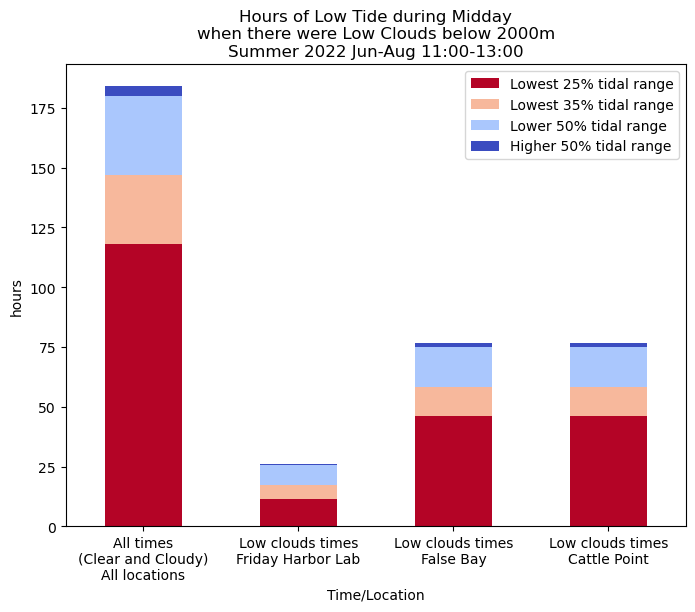

In [47]:
fig, ax = plt.subplots(figsize=(8,6))

tide2022.plot(ax=ax, x='Time/Location', kind='bar', stacked=True, cmap = "coolwarm_r")
plt.title("Hours of Low Tide during Midday\nwhen there were Low Clouds below 2000m\nSummer 2022 Jun-Aug 11:00-13:00" )
plt.ylabel("hours")
plt.xticks(rotation = 0)

In [55]:
tide2022 = pd.DataFrame([[low_25, low_35 + low_50, high_50], 
                        #  fhl_midday_clear_tide_hrs,
                        #  fb_midday_clear_tide_hrs,
                        #  cp_midday_clear_tide_hrs,
                         fhl_midday_lowclouds_tide_hrs,
                         fb_midday_lowclouds_tide_hrs,
                         cp_midday_lowclouds_tide_hrs
                         ], 
                         columns=['Lowest 25% tidal range', 'Lower 50% tidal range', 'Higher 50% tidal range'])

tide2022["Time/Location"] = ["All times\nAll locations", 
                            #  "Clear sky times\nFriday Harbor Lab", 
                            #  "Clear sky times\nFalse Bay", 
                            #  "Clear sky times\nCattle Point",
                             "Low clouds times\nFriday Harbor Lab",
                             "Low clouds times\nFalse Bay",
                             "Low clouds times\nCattle Point"]
tide2022

,Lowest 25% tidal range,Lower 50% tidal range,Higher 50% tidal range,Time/Location
0,118.00,62.00,4.00,All times\nAll locations
1,11.25,14.25,0.50,Low clouds times\nFriday Harbor Lab
2,46.33,28.50,1.92,Low clouds times\nFalse Bay
3,46.33,28.50,1.92,Low clouds times\nCattle Point


### 25, 50, 100

(array([0, 1, 2, 3]),
 [Text(0, 0, 'All times\nAll locations'),
  Text(1, 0, 'Low clouds times\nFriday Harbor Lab'),
  Text(2, 0, 'Low clouds times\nFalse Bay'),
  Text(3, 0, 'Low clouds times\nCattle Point')])

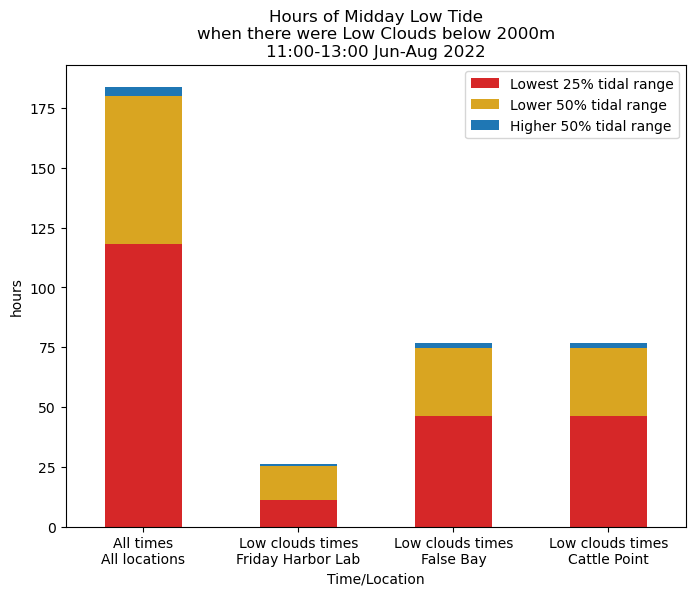

In [57]:
from matplotlib.colors import LinearSegmentedColormap

my_cmap = LinearSegmentedColormap.from_list("", ["tab:red", "goldenrod", "tab:blue"])

fig, ax = plt.subplots(figsize=(8,6))

tide2022.plot(ax=ax, x='Time/Location', kind='bar', stacked=True, cmap = my_cmap)
plt.title("Hours of Midday Low Tide\nwhen there were Low Clouds below 2000m\n11:00-13:00 Jun-Aug 2022" )
plt.ylabel("hours")
plt.xticks(rotation = 0)